In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

from prettytable import PrettyTable

In [3]:
# Specify GPU
device = torch.device("cuda")

In [4]:
# Change to your own directory
try:
    os.chdir("/content/gdrive/MyDrive/Suicide_Detection")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


In [5]:
# Set seeds for reproducibility
import random
import numpy as np
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(0)

In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Load dataset
df = pd.read_csv('reddit_suicide_detection_final_clean.csv', header=0)
df.drop(columns=['text'], axis=1, inplace=True)
df = df.rename(columns={"cleaned_text": "text"})
classes = {"suicide": 1, "non-suicide": 0}
df = df.replace({"class": classes})
df = df[df['text'].notnull()]
df

,class,text
0,1,sex wife threaten suicide recently leave wife ...
1,0,weird not affect compliment come know girl but...
2,0,finally never hear bad year swear fucking god ...
3,1,need help help cry hard
4,1,end tonight not anymore quit
...,...,...
174170,0,today went sled friend not like but pretty big...
174171,0,not like rock not go but
174172,0,tell friend not lonely deprive buy little nigh...
174173,0,pee probably taste like salty tea drink pee co...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Encode the labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['class'])


<ipython-input-7-208485ff2a2b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = le.fit_transform(df['class'])


In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
# Pad the sequences to have uniform length
max_sequence_length = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
# Labels
y = df['label'].values

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Vocabulary size for embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from gensim.models import Word2Vec

# Assuming `sequences` is a list of lists where each sub-list is a sequence of tokens corresponding to a sentence
words = [[tokenizer.index_word[i] for i in seq if i != 0] for seq in sequences]


In [ ]:
# Train a Word2Vec model
word_vectors = Word2Vec(sentences=words, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, 100)) # Assuming 100 dimensions for the Word2Vec vectors
for word, i in tokenizer.word_index.items():
    if word in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[word]

# Model 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping


model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length, trainable=False),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the first model
history1 = model1.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2
                      #, callbacks=[early_stopping]
                      )

Epoch 1/30
1741/1741 [==============================] - 12s 6ms/step - loss: 0.3487 - accuracy: 0.8547 - f1_m: 0.7807 - precision_m: 0.8472 - recall_m: 0.7394 - val_loss: 0.3053 - val_accuracy: 0.8748 - val_f1_m: 0.8142 - val_precision_m: 0.9345 - val_recall_m: 0.7268
Epoch 2/30
1741/1741 [==============================] - 10s 6ms/step - loss: 0.2532 - accuracy: 0.9015 - f1_m: 0.8650 - precision_m: 0.8999 - recall_m: 0.8384 - val_loss: 0.2704 - val_accuracy: 0.8924 - val_f1_m: 0.8452 - val_precision_m: 0.9294 - val_recall_m: 0.7801
Epoch 3/30
1741/1741 [==============================] - 11s 6ms/step - loss: 0.2151 - accuracy: 0.9182 - f1_m: 0.8884 - precision_m: 0.9144 - recall_m: 0.8690 - val_loss: 0.2493 - val_accuracy: 0.9045 - val_f1_m: 0.8733 - val_precision_m: 0.8771 - val_recall_m: 0.8746
Epoch 4/30
1741/1741 [==============================] - 9s 5ms/step - loss: 0.1852 - accuracy: 0.9306 - f1_m: 0.9063 - precision_m: 0.9261 - recall_m: 0.8918 - val_loss: 0.2508 - val_accuracy: 

In [ ]:
# Evaluate the model
test_loss1, test_acc1, test_f1score1, test_precision1, test_recall1 = model1.evaluate(X_test, y_test)
print(f"Test Accuracy for CNN Model without pretrained embeddings: {test_acc1}")

1088/1088 [==============================] - 3s 3ms/step - loss: 0.8780 - accuracy: 0.8812 - f1_m: 0.8416 - precision_m: 0.8366 - recall_m: 0.8583
Test Accuracy for Model without pretrained embeddings: 0.881173312664032


# Model 2

In [ ]:
# model2 = Sequential([
#     Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
#     Conv1D(filters=128, kernel_size=3, activation='relu'),  # Smaller kernel size
#     Dropout(0.5),  # Added dropout
#     Conv1D(filters=128, kernel_size=4, activation='relu'),  # Additional conv layer with different kernel size
#     GlobalMaxPooling1D(),
#     Dense(64, activation='relu', kernel_regularizer=L2(0.01)),  # Increased units and added L2 regularization
#     Dropout(0.5),  # Added dropout
#     Dense(1, activation='sigmoid')
# ])

model2= Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_sequence_length),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the model with early stopping
history2 = model2.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2,
                      callbacks=[early_stopping]
                      )

Epoch 1/30
1741/1741 [==============================] - 36s 20ms/step - loss: 0.2390 - accuracy: 0.9047 - f1_m: 0.8737 - precision_m: 0.8846 - recall_m: 0.8693 - val_loss: 0.2087 - val_accuracy: 0.9180 - val_f1_m: 0.8868 - val_precision_m: 0.9243 - val_recall_m: 0.8567
Epoch 2/30
1741/1741 [==============================] - 13s 7ms/step - loss: 0.1831 - accuracy: 0.9300 - f1_m: 0.9066 - precision_m: 0.9158 - recall_m: 0.9013 - val_loss: 0.2043 - val_accuracy: 0.9210 - val_f1_m: 0.8902 - val_precision_m: 0.9329 - val_recall_m: 0.8556
Epoch 3/30
1741/1741 [==============================] - 12s 7ms/step - loss: 0.1563 - accuracy: 0.9417 - f1_m: 0.9218 - precision_m: 0.9295 - recall_m: 0.9177 - val_loss: 0.1981 - val_accuracy: 0.9244 - val_f1_m: 0.8984 - val_precision_m: 0.9098 - val_recall_m: 0.8915
Epoch 4/30
1741/1741 [==============================] - 12s 7ms/step - loss: 0.1323 - accuracy: 0.9512 - f1_m: 0.9350 - precision_m: 0.9404 - recall_m: 0.9324 - val_loss: 0.2066 - val_accuracy

In [ ]:
# Evaluate the model
test_loss2, test_acc2, test_f1score2, test_precision2, test_recall2 = model2.evaluate(X_test, y_test)
print(f"Test Accuracy for CNN Model with customized Word2Vec embeddings: {test_acc2}")

1088/1088 [==============================] - 4s 4ms/step - loss: 0.2018 - accuracy: 0.9224 - f1_m: 0.8941 - precision_m: 0.9059 - recall_m: 0.8902
Test Accuracy for Model with customized Word2Vec embeddings: 0.9224293828010559


In [ ]:
table = PrettyTable()
table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

table.add_row(['CNN without pre trained embedding weights',
               format(test_acc1, '.4f'),
               format(test_precision1, '.4f'),
               format(test_recall1, '.4f'),
               format(test_f1score1, '.4f')])

table.add_row(['CNN with Word2Vec pre trained embedding weights',
               format(test_acc2, '.4f'),
               format(test_precision2, '.4f'),
               format(test_recall2, '.4f'),
               format(test_f1score2, '.4f')])

print(table)

+-------------------------------------------------+----------+-----------+--------+----------+
|                      Model                      | Accuracy | Precision | Recall | F1 Score |
+-------------------------------------------------+----------+-----------+--------+----------+
|    CNN without pre trained embedding weights    |  0.8812  |   0.8366  | 0.8583 |  0.8416  |
| CNN with Word2Vec pre trained embedding weights |  0.9224  |   0.9059  | 0.8902 |  0.8941  |
+-------------------------------------------------+----------+-----------+--------+----------+


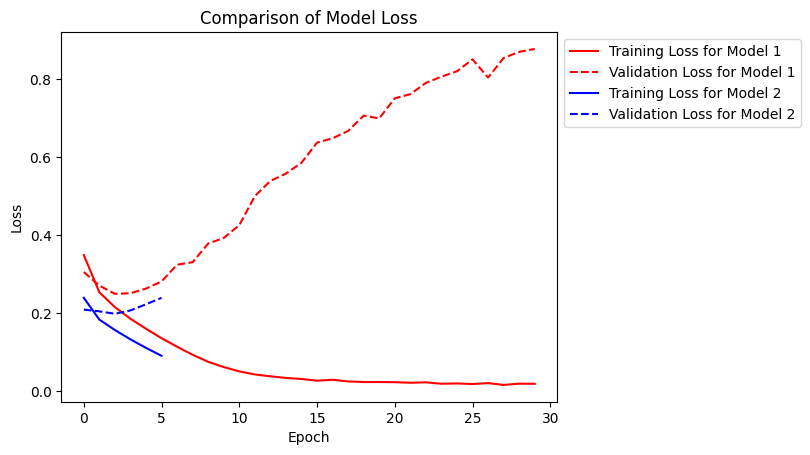

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values for Model 1
plt.plot(history1.history['loss'], 'r-')
plt.plot(history1.history['val_loss'], 'r--')
# Plot training & validation accuracy values for Model 2
plt.plot(history2.history['loss'], 'b-')
plt.plot(history2.history['val_loss'], 'b--')
plt.title('Comparison of Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#plt.xlim(-0.5, 10)
#plt.xticks(np.arange(-0.5, 5, 0.1))
plt.legend(['Training Loss for Model 1', 'Validation Loss for Model 1', 'Training Loss for Model 2', 'Validation Loss for Model 2'], bbox_to_anchor=(1, 1))
plt.show()
